In [1]:
#Imports

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn.preprocessing import scale, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from imblearn.combine import SMOTETomek

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

df = pd.read_csv("/content/drive/MyDrive/Data Projects/data.csv")

## General structure of the dataset

### Displaying the first few rows

In [4]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

### Looking for missing values

In [5]:
# get null values
null_values = df.isnull().sum().sum()
print('Null:', null_values)
# get nan values
nan_values = np.isnan(df.values).sum()
print('Nan:', nan_values)

Null: 0
Nan: 0


No missing values are present in the dataset.

### Displaying the feature names and types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

We see that all features other than  "Net Income Flag" and "Liability-Assets Flag" are numerical. 

In [7]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686


### Displaying the disributions of the features

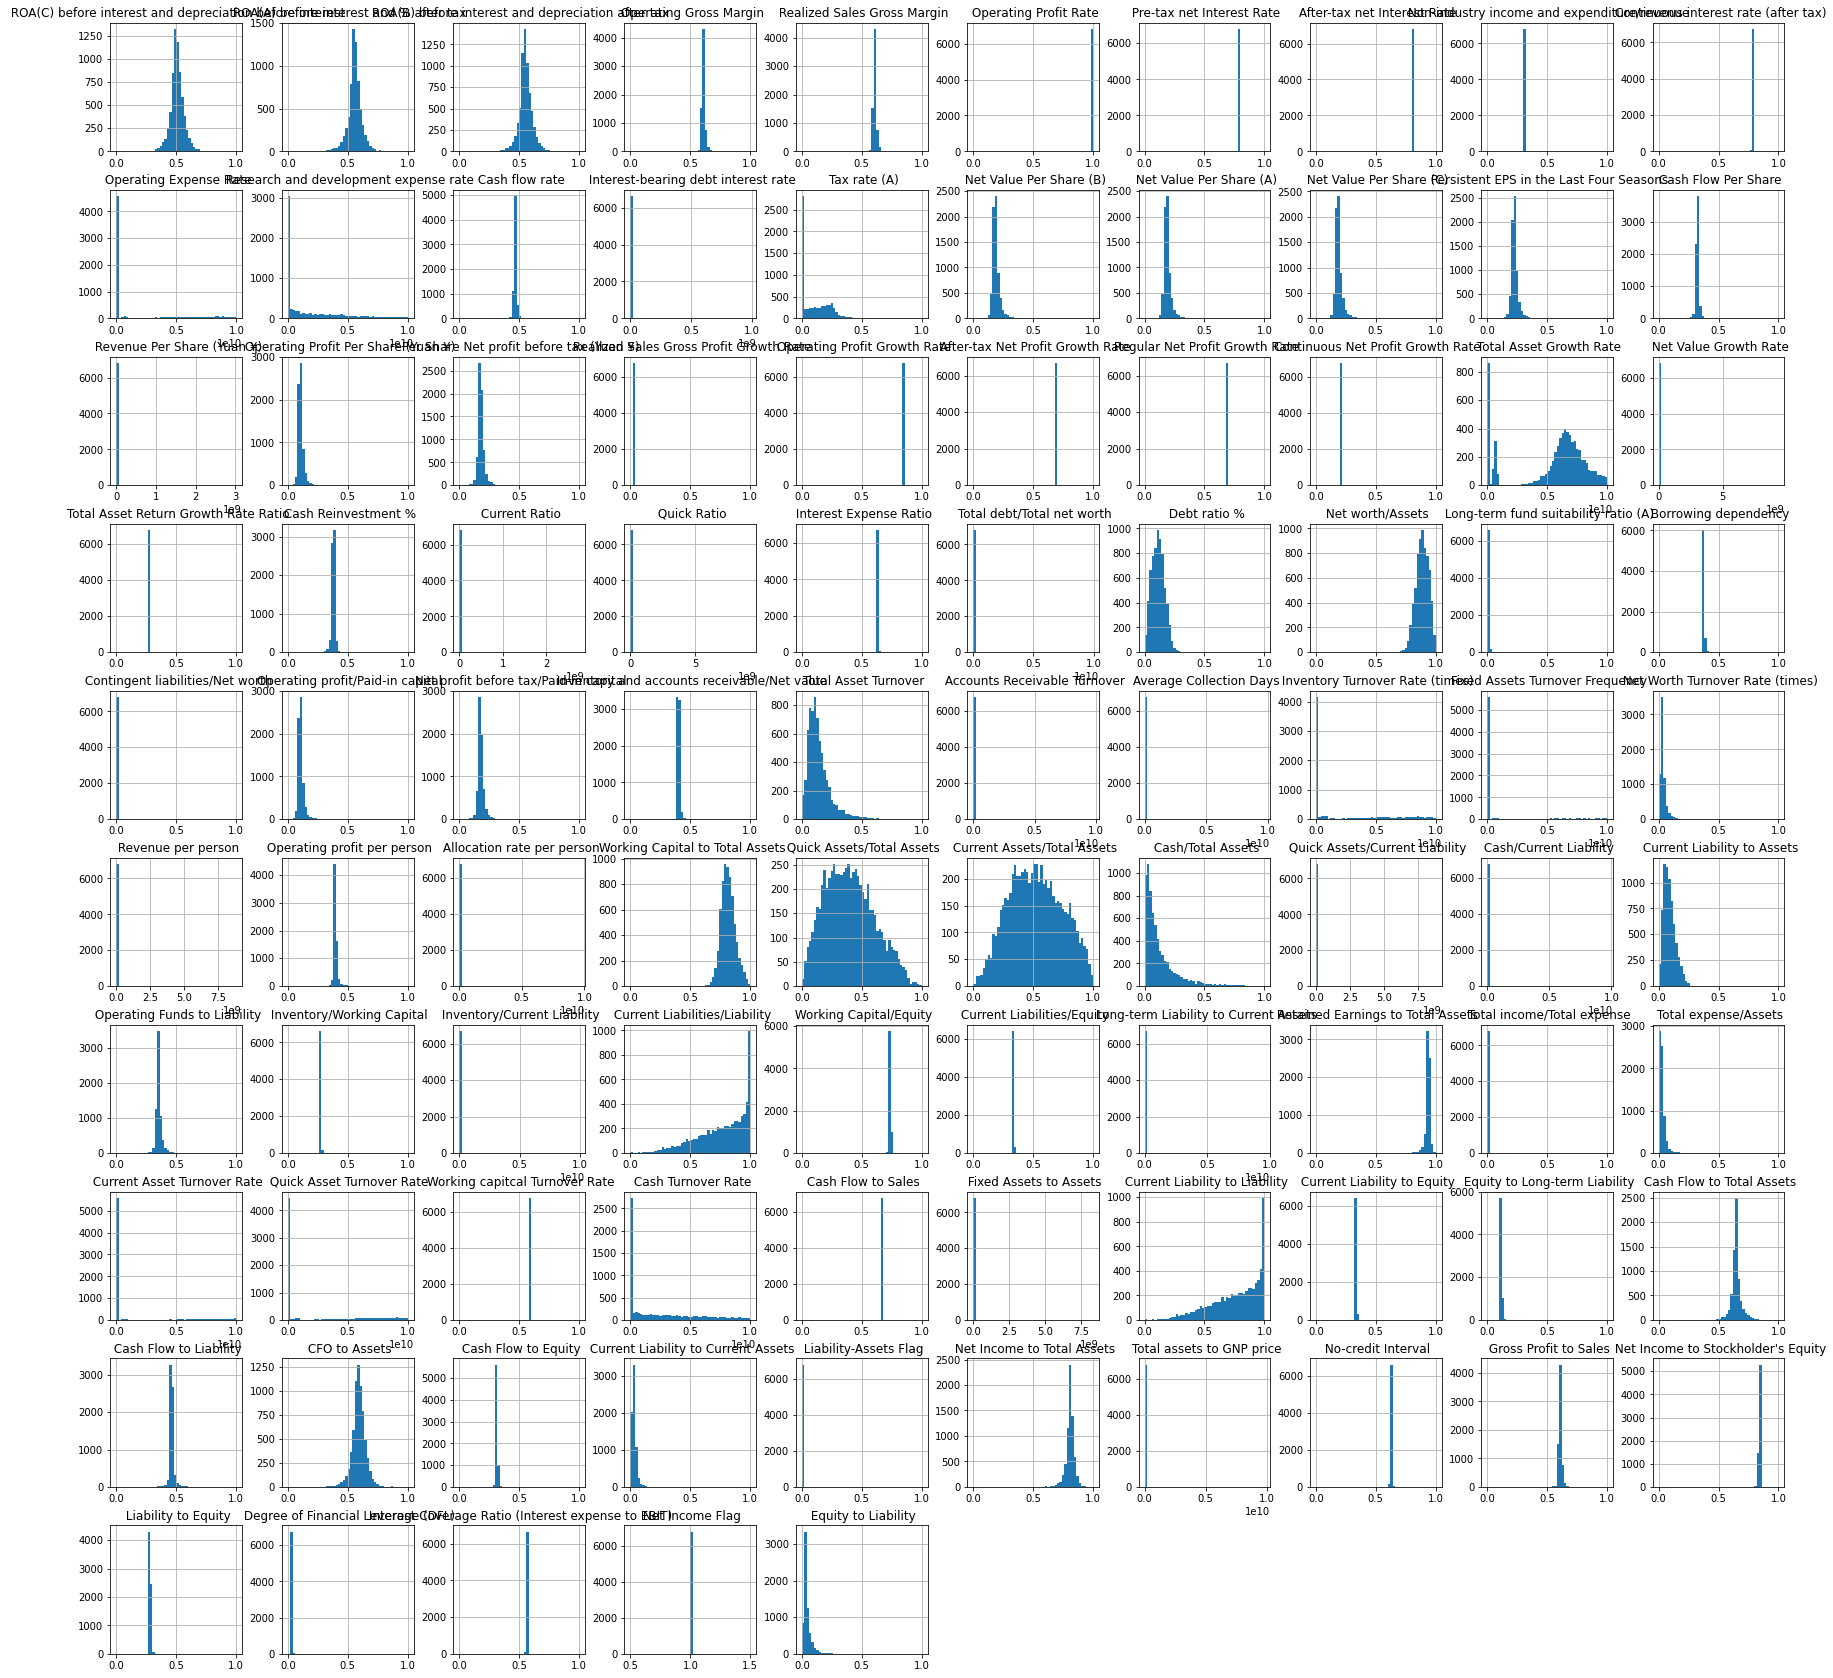

In [8]:
Y = df['Bankrupt?']
X = df.drop('Bankrupt?', axis=1)

X.hist(figsize = (30,30),bins = 50)
plt.show()

It is apparent that our features come in groups of different distributions, some resembling exponential, some more similar to cauchy and others, weibull distribution. We also know that most features are numerical and are on different scales. The two flag features (non-numerical) are inconsequential as all data points have the same value for them.

In addition to distributions, it helps to see box plots of some features to observe outliers.

In [9]:
# detecting outliers based on inter-quartile range

Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
df_outliers=( (df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)) ).sum() / df.shape[0] * 100
print("Average percentage of outliers per feature:")
print( round(df_outliers.mean()), "%")

Average percentage of outliers per feature:
8 %


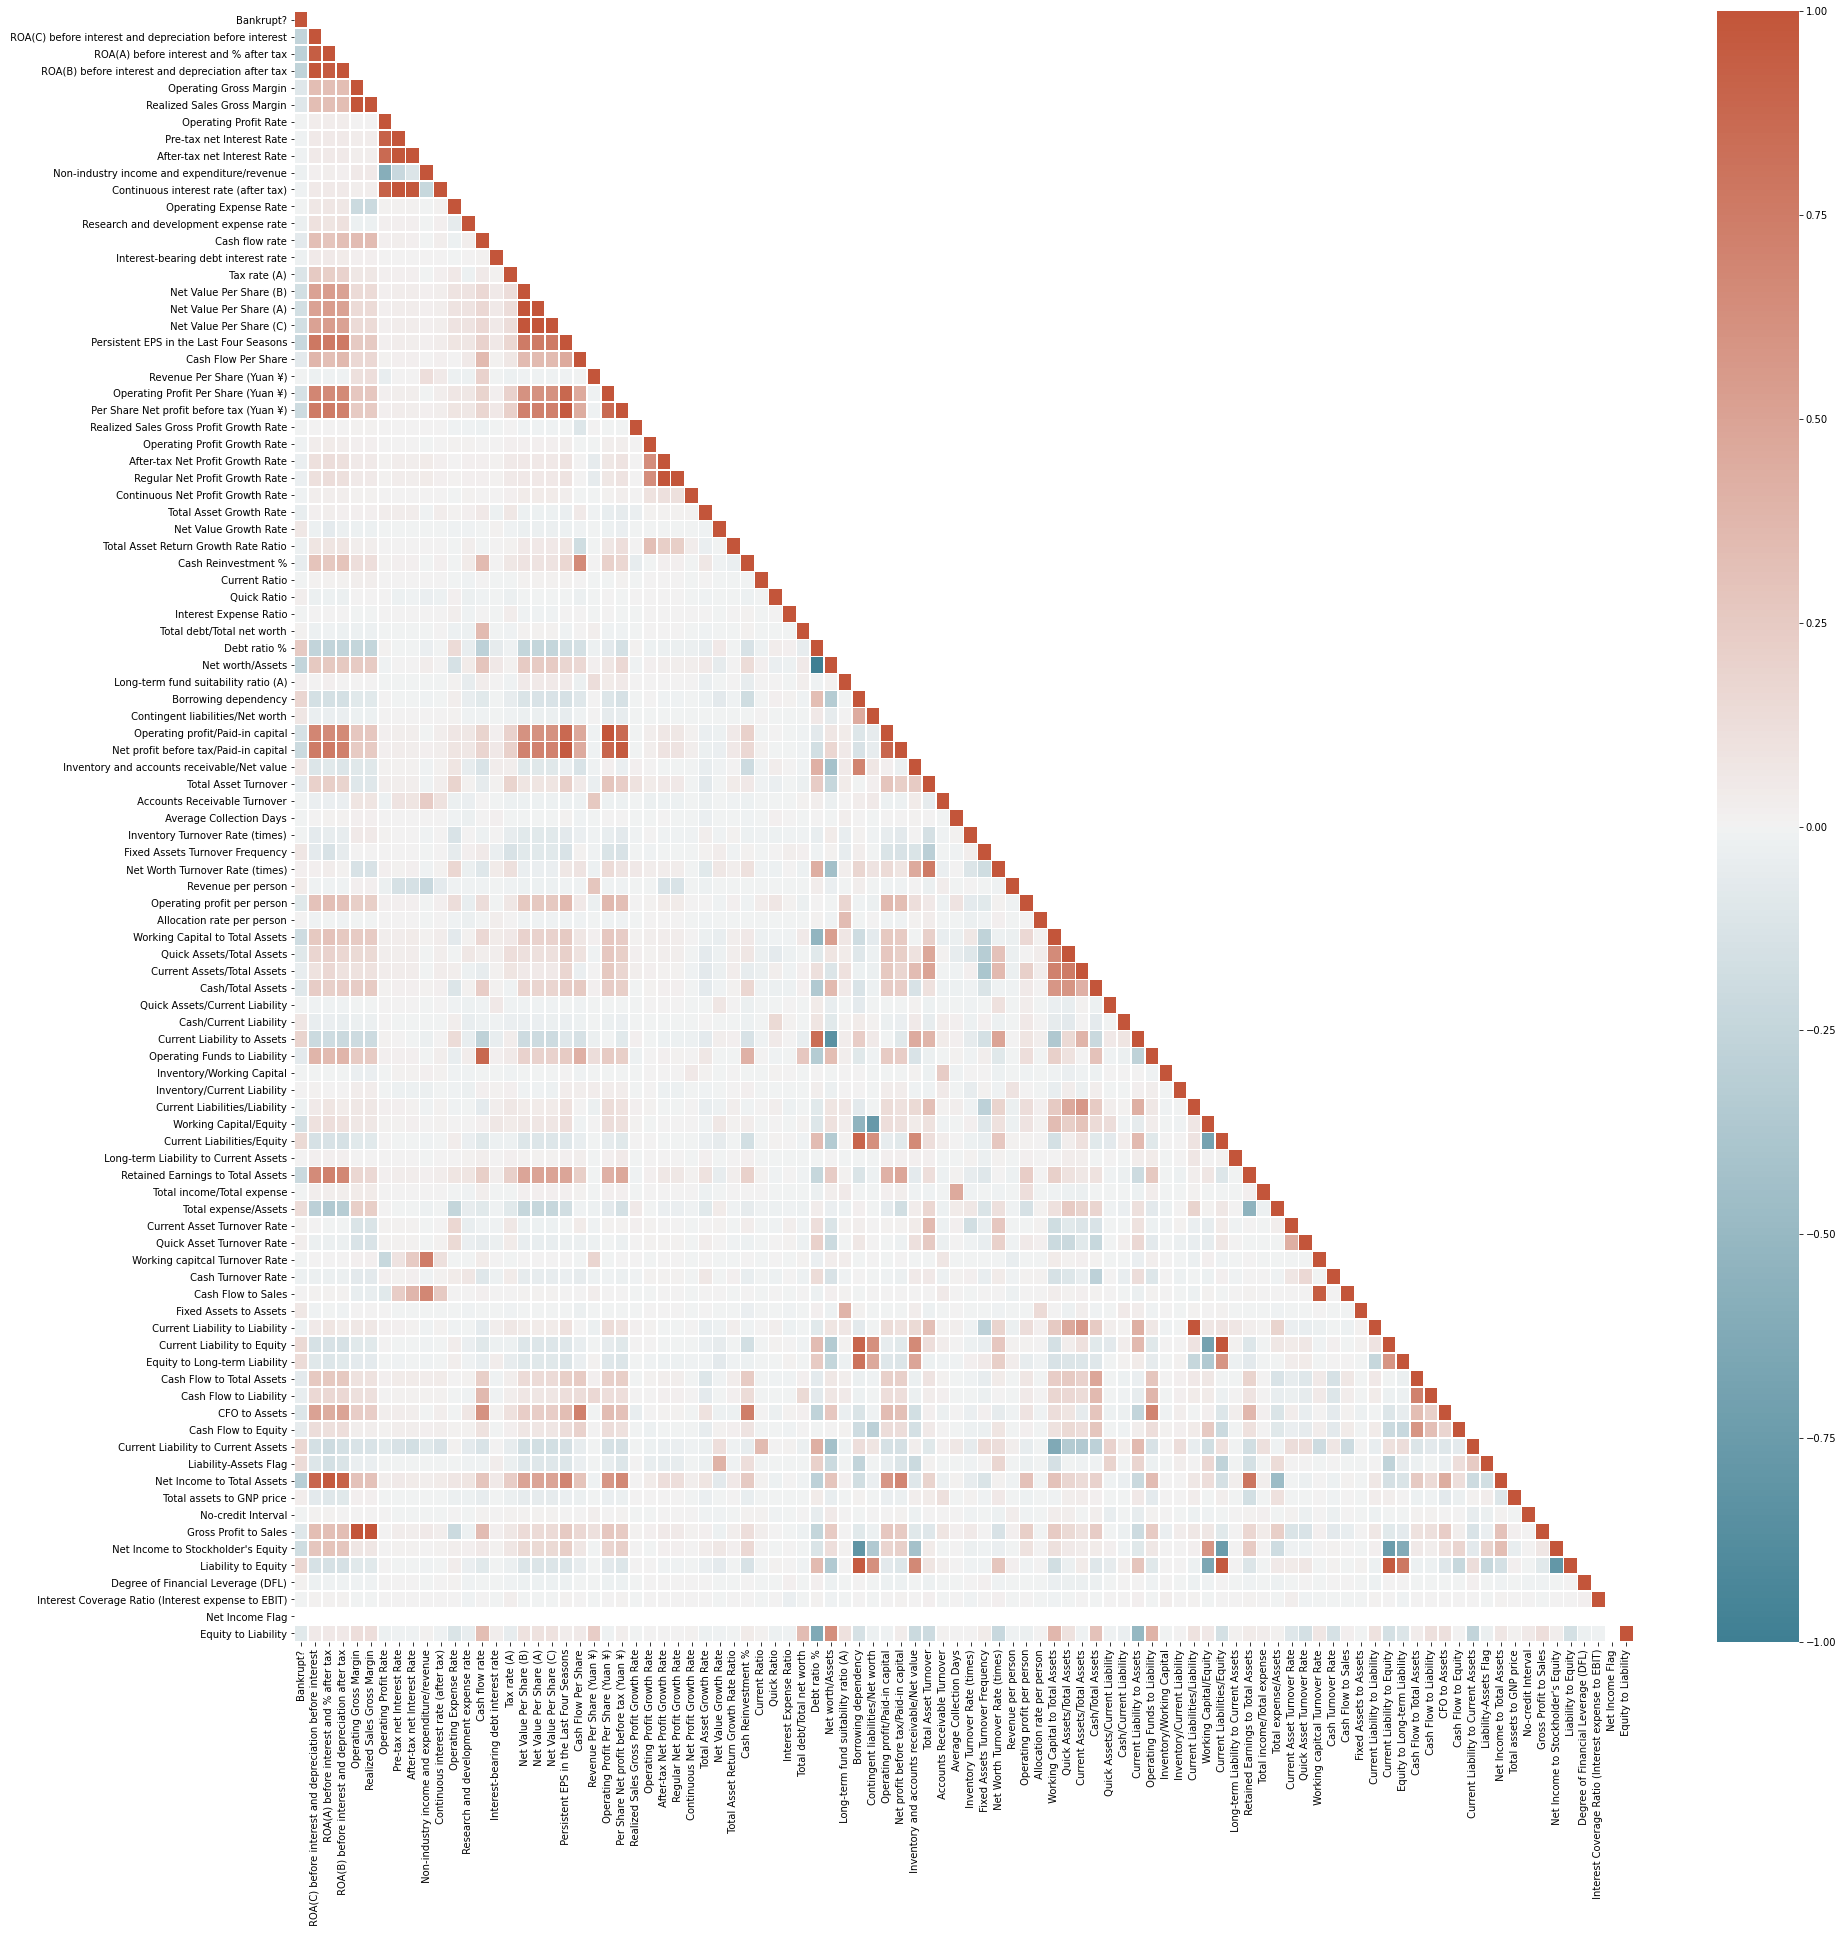

In [10]:
corr_mat = df.corr()
#lower trainglular part of the correlation matrix
lt_mat = corr_mat.where(np.tril(np.ones(corr_mat.shape)).astype(np.bool))

fig, ax = plt.subplots(figsize=(30,30))   

cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(lt_mat, linewidths=0.5,cmap=cmap, ax=ax)
plt.show()

In [11]:
print("Bankrupt?")
print("No   : " , df['Bankrupt?'].value_counts()[0] , " -> ", round( 100*df['Bankrupt?'].value_counts()[0]/len(df) ),"%" )
print("Yes  : " , df['Bankrupt?'].value_counts()[1] , "  -> ", round( 100*df['Bankrupt?'].value_counts()[1]/len(df) ),"%" )

Bankrupt?
No   :  6599  ->  97 %
Yes  :  220   ->  3 %


There are an number of decisions to be made on how to preprocess our data:

1 - Feautures comprising our data are on different scales, should we transform the data to account for it? 

    - We will use robust scaling to minimize any skewing effects caused by the outliers (8% on avg. per feature) 
    
2- Our data is drastically skewed with the positive label representing only 3% of data points. Then, should we include steps to balance our training dataset? If so, which methods should we use? 

    - We will carry out the entire process first without and later with artificially balaced data. Then, we will compare the results.
    
3- Our data is very high dimensional. Should we choose subsets of the available features?

    - We will use ANOVA F measure to assign scores to each feature and select k features with the highest scores. We will train our models with a range of different k values up to k = 95 (all features) and keep the best performing setup.
 

In [12]:
def standardize(df):

    df_copy = df.copy()
    for column in df_copy.columns:
        
        if df_copy[column].max() == df_copy[column].min():
            df_copy[column] = df_copy[column]/df_copy[column].min()    
        else:
            df_copy[column] = (df_copy[column] - df_copy[column].mean()) / df_copy[column].std()  
        
    return df_copy

def robust_scaling(df):

    df_copy = df.copy()
    
    for column in df_copy.columns:
        if df_copy[column].max() == df_copy[column].min():
            df_copy[column] = df_copy[column]/df_copy[column].min()
        else:
            quantile_diff = (df_copy[column].quantile(0.75) - df_copy[column].quantile(0.25))
            if quantile_diff != 0:
                df_copy[column] = (df_copy[column] - df_copy[column].median())  / (df_copy[column].quantile(0.75) - df_copy[column].quantile(0.25))
            else:
                df_copy[column] = (df_copy[column] - df_copy[column].median())  / df_copy[column].std() 
            
    return df_copy

### Robust Scaling

In [13]:
Y = df['Bankrupt?']
X = df.drop('Bankrupt?', axis=1)

x = X.values
y = Y.values

scaler = RobustScaler()
#x_scaled = scaler.fit_transform(X)
#X_scaled = pd.DataFrame(x_scaled)
X_scaled = standardize(X)


#### Train-Test Split

In [14]:
#X_cv , Y_cv will be used for model and parameter selection with cross validation
X_cv,X_test,Y_cv,Y_test  = train_test_split(X_scaled, Y, test_size=0.1, stratify = Y, random_state = 42)

#### Balancing the training set

A version of the training data resampled to increase the ratio of "Bankrupt? = 1" labelled data points will evaluated along with the original training set. A combination of over and under-sampling ( SMOTE + Tomek ) will be used.

In [16]:
smt = SMOTETomek(ratio=0.2)
X_smt, y_smt = smt.fit_sample(X_cv, Y_cv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Machine Learning Models

### Logistic Regression

#### Without Dataset Resampling

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import sys, warnings
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)




In [ ]:
clf = LogisticRegression().fit(X_cv,Y_cv)
y_pred = clf.predict(X_test)

# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(Y_test,y_pred)))
print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
print('F1 Score : ' + str(f1_score(Y_test,y_pred)))

Accuracy Score : 0.967741935483871
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    Log_param_grid = {"C":np.logspace(-8,1,10), "penalty":["none","l1","l2"]}

    #number of features to keep
    k_vals = [5,10,20,40, 60, 80, 95]
    log_list = []

    best_score = 0
    best_params = ()


    for k in k_vals:
        
            print("For k = ",k)
        
            #choosing k features
            best_k = SelectKBest(score_func=f_classif , k=k)
            fit = best_k.fit(X_cv, Y_cv)
            X_k = best_k.fit_transform(X_cv, Y_cv)
            
            #logistic regression
            log_model = LogisticRegression(class_weight ='balanced',solver ='saga', max_iter=500)  
            search = GridSearchCV(log_model, Log_param_grid, scoring ='f1',
                                  cv=sss, n_jobs=-1 )

            results = search.fit(X_k, Y_cv)
            print('Best Training F1 Score: %.3f' % results.best_score_)
            print('Config: %s' % results.best_params_)
            print("-----")
            
            if results.best_score_ > best_score:
                best_score = results.best_score_
                best_params = ("log",results.best_params_ )
            
            log_list.append(results)



For k =  5
Best Training Accuracy: 0.299
Config: {'C': 1e-05, 'penalty': 'l2'}
-----
For k =  10
Best Training Accuracy: 0.303
Config: {'C': 1e-05, 'penalty': 'l2'}
-----
For k =  20
Best Training Accuracy: 0.325
Config: {'C': 1e-07, 'penalty': 'l2'}
-----
For k =  40
Best Training Accuracy: 0.310
Config: {'C': 1e-06, 'penalty': 'l2'}
-----
For k =  60
Best Training Accuracy: 0.312
Config: {'C': 1e-05, 'penalty': 'l2'}
-----
For k =  80
Best Training Accuracy: 0.313
Config: {'C': 1e-05, 'penalty': 'l2'}
-----
For k =  95
Best Training Accuracy: 0.314
Config: {'C': 1e-05, 'penalty': 'l2'}
-----


Overall, the balanced training accuracy does not change dramatically when the number of feautres increases. K can be taken between 10 and 20 to limit data size for better efficiency. 

In [52]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    best_10 = SelectKBest(score_func=f_classif , k=15)
    best_10.fit(X_cv, Y_cv)
    X_10 = best_10.fit_transform(X_cv, Y_cv)

    best_logit = LogisticRegression( C = 0.01, penalty='l1', class_weight ='balanced', solver ='saga', max_iter = 500 )
    best_logit.fit(X_10, Y_cv)

    X_test_10 = best_10.fit_transform(X_test, Y_test)
    y_pred = best_logit.predict(X_test_10)

    # Model Evaluation metrics 

    print('Accuracy Score : ' + str(accuracy_score(Y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(Y_test,y_pred)))

Accuracy Score : 0.9457478005865103
Precision Score : 0.2972972972972973
Recall Score : 0.5
F1 Score : 0.3728813559322034


The comparatively high accuracy score does not indicate good performance in the light of the low precision, recall and F1 scores.

In [59]:
print("With resampled training data:")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    Log_param_grid = {"C":np.logspace(-5,3,9), "penalty":["none","l1","l2"]}

    #number of features to keep
    k_vals = [5,10,20,40, 60, 80, 95]
    smt_log_list = []

    best_score = 0
    best_params = ()


    for k in k_vals:
        
            print("For k = ",k)
        
            #choosing k features
            best_k = SelectKBest(score_func=f_classif , k=k)
            fit = best_k.fit(X_smt, y_smt)
            X_k = best_k.fit_transform(X_smt, y_smt)
            
            #logistic regression
            log_model = LogisticRegression(class_weight ='balanced',solver ='saga', max_iter=500)  
            search = GridSearchCV(log_model, Log_param_grid, scoring ='f1',
                                  cv=sss, n_jobs=-1 )

            results = search.fit(X_k, y_smt)
            print('Best Training F1 Score: %.3f' % results.best_score_)
            print('Config: %s' % results.best_params_)
            print("-----")
            
            if results.best_score_ > best_score:
                best_score = results.best_score_
                best_params = ("log",results.best_params_ )
            
            smt_log_list.append(results)


With resampled training data:
For k =  5


KeyboardInterrupt: ignored

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    best_10 = SelectKBest(score_func=f_classif , k=15)
    best_10.fit(X_smt, y_smt)
    X_10 = best_10.fit_transform(X_smt, y_smt)

    best_logit = LogisticRegression( C = 0.01, penalty='l1', class_weight ='balanced', solver ='saga', max_iter = 500 )
    best_logit.fit(X_10, y_smt)

    X_test_10 = best_10.fit_transform(X_test, Y_test)
    y_pred = best_logit.predict(X_test_10)

    # Model Evaluation metrics 

    print('Accuracy Score : ' + str(accuracy_score(Y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(Y_test,y_pred)))


Recall appears to be worse compared to the non-resampled version. Overall, resampling the data does not appear to result in significant improvement in performance.

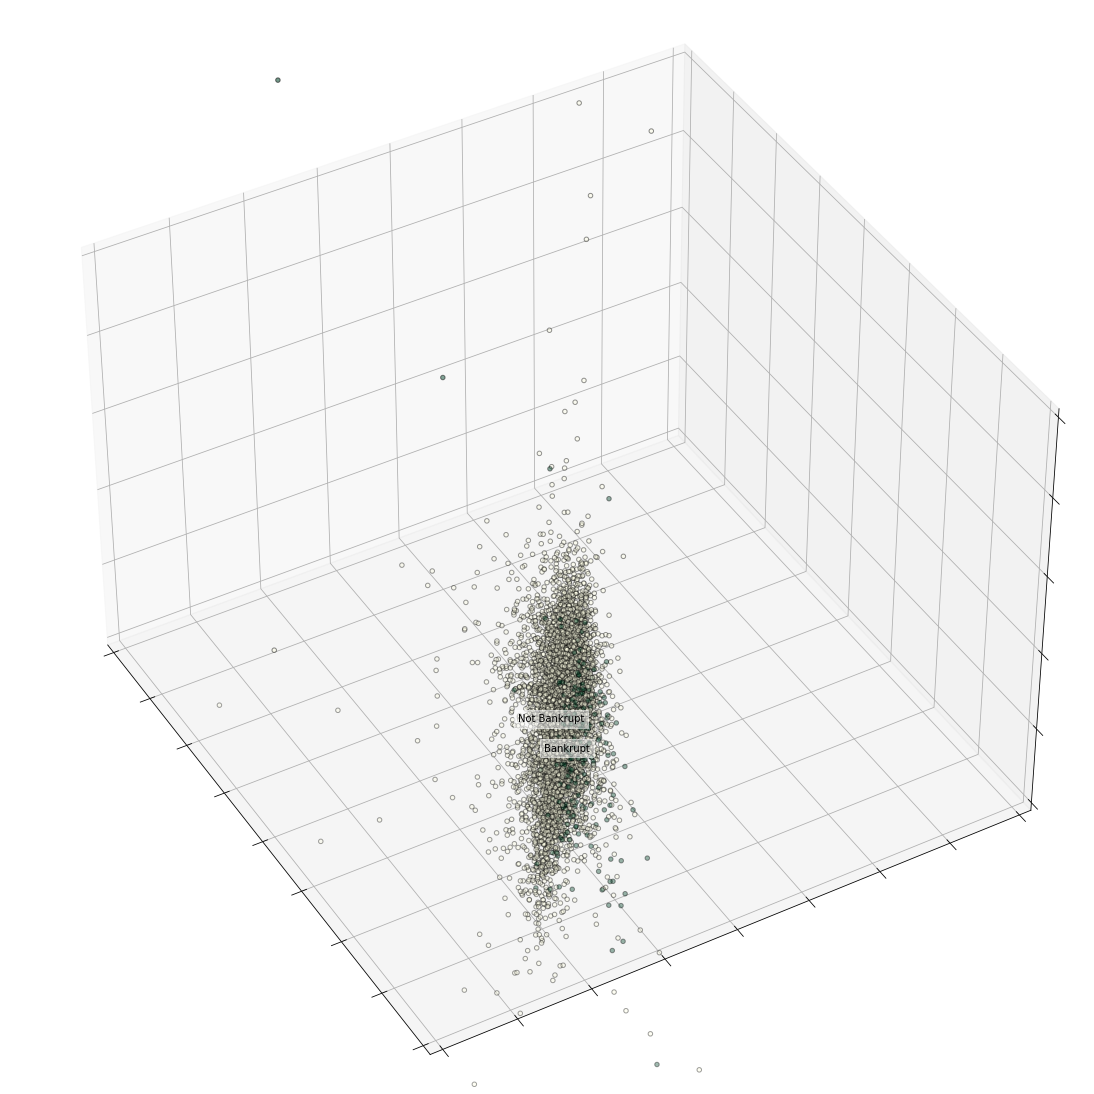

In [ ]:
fig = plt.figure(1, figsize=(15, 15))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=40, azim=150)

plt.cla()
pca = decomposition.PCA(n_components=20)
pca.fit(x)
scores = pca.transform(x)

for name, label in [('Bankrupt', 1), ('Not Bankrupt', 0)]:
    ax.text3D(scores[y == label, 0].mean(),
              scores[y == label, 1].mean() + 1.5,
              scores[y == label, 2].mean(),
               name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))


ax.scatter(scores[:, 0], scores[:, 1], scores[:, 2], c=y, cmap='YlGn',
           edgecolor='k')

ax.set_xlim(-40,40)

ax.set_ylim(-40,40)

ax.set_zlim(0,10)


ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

In [ ]:
explained_variance = pca.explained_variance_ratio_
print('Explained variation per principal component: {}'.format(explained_variance))
    

explained_variance = np.insert(explained_variance, 0, 0)
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=4)) 
      

Explained variation per principal component: [0.13346977 0.07213753 0.05036682 0.0472448  0.04234713 0.03220201
 0.03049226 0.02934013 0.02801654 0.02155604 0.0205799  0.01982231
 0.01781151 0.01591869 0.01572232 0.01527418 0.01499282 0.01376761
 0.01251793 0.01238474]


In [ ]:
pc_df = pd.DataFrame(['','PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11', 'PC12', 'PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20'], columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])


df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)
df_explained_variance


,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.0000
1,PC1,0.133470,0.1335
2,PC2,0.072138,0.2056
3,PC3,0.050367,0.2560
4,PC4,0.047245,0.3032
5,PC5,0.042347,0.3455
6,PC6,0.032202,0.3777
7,PC7,0.030492,0.4082
8,PC8,0.029340,0.4375
9,PC9,0.028017,0.4655


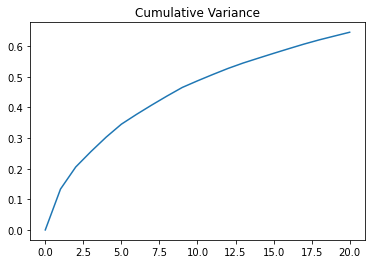

In [ ]:
plt.plot(cumulative_variance)
plt.title("Cumulative Variance")
plt.show()

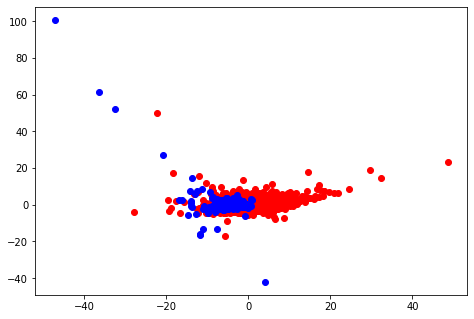

In [ ]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(scores[y == 0, 0],scores[y == 0, 1], color='r')
ax.scatter(scores[y == 1,0],scores[y == 1, 1], color='b')

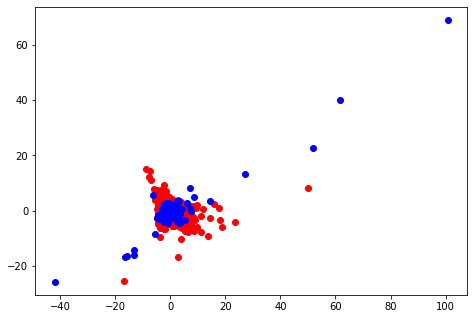

In [ ]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(scores[y == 0, 1],scores[y == 0, 2], color='r')
ax.scatter(scores[y == 1,1],scores[y == 1, 2], color='b')

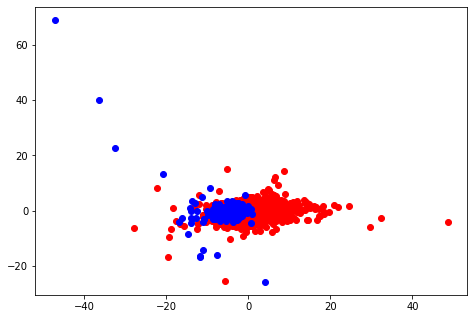

In [ ]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(scores[y == 0, 0],scores[y == 0, 2], color='r')
ax.scatter(scores[y == 1,0],scores[y == 1, 2], color='b')